In [79]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import sys

In [2]:
# Import modules from parent directory
sys.path.insert(0,'..')

In [4]:
from ipynb.fs.full.training_preprocessing import GetDataset

In [5]:
df = GetDataset()
df

,subtotal,transaction_count,rain,temperature,holiday,oil_price,workforce_type_1,workforce_type_2,workforce_type_3,workforce_type_4,time_idx,constant_group,year,month,day,hour
0,428.03,11.0,0.0,12.7,0,69.62,1.0,2.0,3.0,0.0,0,0,2021,5,17,10
1,324.78,15.0,0.0,13.4,0,69.62,1.0,2.0,3.0,1.0,1,0,2021,5,17,11
2,279.75,12.0,0.0,13.6,0,69.62,1.0,2.0,3.0,1.0,2,0,2021,5,17,12
3,1630.59,29.0,0.0,14.1,0,69.62,1.0,2.0,3.0,1.0,3,0,2021,5,17,13
4,1166.10,18.0,0.0,15.9,0,69.62,1.0,2.0,3.0,1.0,4,0,2021,5,17,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5062,4779.11,82.0,0.0,0.0,0,83.45,1.0,4.0,5.0,0.0,5062,0,2022,11,30,14
5063,2460.84,54.0,0.0,0.0,0,83.45,1.0,4.0,5.0,0.0,5063,0,2022,11,30,15
5064,2026.30,43.0,0.0,0.0,0,83.45,1.0,4.0,5.0,0.0,5064,0,2022,11,30,16
5065,2346.13,44.0,0.0,0.0,0,83.45,1.0,4.0,5.0,0.0,5065,0,2022,11,30,17


In [6]:
# set x equal to all columns except for the transaction_count and workforce_type_1
x = df.drop(['transaction_count', 'workforce_type_1','workforce_type_2', 'workforce_type_3','workforce_type_4'], axis=1)
# convert x to a 2d array
x = x.values.tolist()


# set y equal to the transaction_count and workforce_type_1 columns
y = df[['transaction_count', 'workforce_type_1', 'workforce_type_2', 'workforce_type_3','workforce_type_4']]
# convert y to an array
y = y.values.tolist()

In [7]:
TEST_SIZE = 0.33

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=TEST_SIZE)

In [8]:
X_train

[[1107.74, 0.0, 20.5, 0.0, 114.4, 3769.0, 0.0, 2022.0, 9.0, 7.0, 17.0],
 [2839.36, 0.0, 11.0, 0.0, 82.42, 1621.0, 0.0, 2021.0, 11.0, 13.0, 11.0],
 [1685.11, 0.0, 13.0, 0.0, 76.45, 357.0, 0.0, 2021.0, 6.0, 25.0, 16.0],
 [1591.38, 0.1, 9.5, 1.0, 108.16, 3029.0, 0.0, 2022.0, 4.0, 18.0, 15.0],
 [1382.78, 0.2, 7.7, 0.0, 99.29, 2546.0, 0.0, 2022.0, 2.0, 23.0, 18.0],
 [2052.54, 0.0, 14.1, 0.0, 91.04, 4668.0, 0.0, 2022.0, 10.0, 17.0, 16.0],
 [2000.83, 0.0, 18.9, 0.0, 108.54, 3742.0, 0.0, 2022.0, 6.0, 7.0, 17.0],
 [1623.97, 0.0, 13.9, 0.0, 127.94, 3520.0, 0.0, 2022.0, 12.0, 6.0, 11.0],
 [2917.62, 0.0, 10.3, 0.0, 82.85, 1649.0, 0.0, 2021.0, 11.0, 16.0, 12.0],
 [1480.01, 0.0, 23.6, 0.0, 95.06, 4162.0, 0.0, 2022.0, 8.0, 22.0, 14.0],
 [452.92, 0.0, 12.7, 0.0, 133.18, 2660.0, 0.0, 2022.0, 8.0, 3.0, 15.0],
 [355.45, 0.0, 17.2, 0.0, 86.83, 4310.0, 0.0, 2022.0, 7.0, 9.0, 18.0],
 [1823.67, 0.0, 17.7, 0.0, 97.99, 3997.0, 0.0, 2022.0, 4.0, 8.0, 11.0],
 [948.58, 0.0, 18.1, 0.0, 72.92, 282.0, 0.0, 2021.0, 6

In [9]:
# Defining custom dataloaders
## train data
class TrainData(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __getData__(self):
        return self.X_data, self.y_data
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))
## test data    
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = TestData(torch.FloatTensor(X_test))

In [10]:
class MultiLabelRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(MultiLabelRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        out = self.linear(x)
        return out


In [43]:
def train(model, optimizer, criterion, num_epochs, train_loader):
    for epoch in range(num_epochs):
        for inputs, targets in train_loader:
            # Forward pass
            outputs = model(inputs)
            # Compute loss
            loss = criterion(outputs, targets)
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # Print progress
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))


In [44]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [58]:
LEARNING_RATE = 0.0001

# Define the model
model = MultiLabelRegression(11, 5)
model.to(device)

# Define the loss function and the optimizer
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
#optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)


In [59]:
train(model, optimizer, criterion, 100, train_data)

Epoch [1/100], Loss: 3896.1328
Epoch [2/100], Loss: 845.1984
Epoch [3/100], Loss: 54.0812
Epoch [4/100], Loss: 5.4008
Epoch [5/100], Loss: 7.2490
Epoch [6/100], Loss: 7.1741
Epoch [7/100], Loss: 7.6292
Epoch [8/100], Loss: 8.0811
Epoch [9/100], Loss: 8.0433
Epoch [10/100], Loss: 7.3819
Epoch [11/100], Loss: 6.2884
Epoch [12/100], Loss: 4.9959
Epoch [13/100], Loss: 3.7152
Epoch [14/100], Loss: 2.6255
Epoch [15/100], Loss: 1.8196
Epoch [16/100], Loss: 1.2955
Epoch [17/100], Loss: 1.0029
Epoch [18/100], Loss: 0.8616
Epoch [19/100], Loss: 0.8062
Epoch [20/100], Loss: 0.7944
Epoch [21/100], Loss: 0.8056
Epoch [22/100], Loss: 0.8157
Epoch [23/100], Loss: 0.8231
Epoch [24/100], Loss: 0.8262
Epoch [25/100], Loss: 0.8286
Epoch [26/100], Loss: 0.8276
Epoch [27/100], Loss: 0.8267
Epoch [28/100], Loss: 0.8259
Epoch [29/100], Loss: 0.8245
Epoch [30/100], Loss: 0.8230
Epoch [31/100], Loss: 0.8207
Epoch [32/100], Loss: 0.8194
Epoch [33/100], Loss: 0.8173
Epoch [34/100], Loss: 0.8159
Epoch [35/100], L

## Evaluating model performance

In [98]:
Xtest = torch.FloatTensor(X_test)
test_loader = DataLoader(dataset=Xtest, batch_size=1)

# Set the model to eval mode and generate a list of predictions for the test data
model.eval()
y_pred_list = []
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
y_pred_list

[[14.913511276245117,
  1.0155662298202515,
  2.928450584411621,
  3.9282257556915283,
  -0.8861402273178101],
 [21.24163246154785,
  1.0611414909362793,
  3.4443819522857666,
  4.4440202713012695,
  -0.898017168045044],
 [21.302244186401367,
  0.9681363105773926,
  2.4676778316497803,
  3.467580795288086,
  -0.09305565804243088],
 [44.8466911315918,
  0.9925220012664795,
  3.322317361831665,
  4.3221049308776855,
  -0.025159865617752075],
 [27.229684829711914,
  1.005133867263794,
  2.8533573150634766,
  3.8529367446899414,
  -0.11100108921527863],
 [28.62119483947754,
  1.0005165338516235,
  3.0828442573547363,
  4.082509517669678,
  -0.15621697902679443],
 [16.2913875579834,
  0.9621493816375732,
  2.4426770210266113,
  3.442563056945801,
  -0.24812424182891846],
 [17.250520706176758,
  0.9859229326248169,
  2.361010789871216,
  3.3606667518615723,
  -0.4069603681564331],
 [33.00254440307617,
  1.0029940605163574,
  3.073110818862915,
  4.072790145874023,
  -0.317455917596817],
 [32

In [99]:
# create an array of only the first object of each array inside y_pred_list
transaction_count_predictions = [a[0] for a in y_pred_list]
transaction_count_actuals = [a[0] for a in y_test]

In [100]:
# Calculate the MSE and MAE between the predictions and the actual values
mse = mean_squared_error(y_test, y_pred_list)
mae = mean_absolute_error(y_test, y_pred_list)

print(f'MSE: {mse:.2f}, MAE: {mae:.2f}')


MSE: 30.08, MAE: 1.71


In [101]:
# Calculate the MSE and MAE between only the transaction_count prediction and the actual values
mse = mean_squared_error(transaction_count_actuals, transaction_count_predictions)
mae = mean_absolute_error(transaction_count_actuals, transaction_count_predictions)

print(f'MSE: {mse:.2f}, MAE: {mae:.2f}')

MSE: 148.67, MAE: 6.76


In [102]:
# Calculate SMAPE between actual and predicted values.
def smape(actual, predicted):
    actual = np.array(actual)
    predicted = np.array(predicted)
    smape_val = (100.0 / actual.size) * np.sum(2.0 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))
    return smape_val

In [103]:
smape = smape(y_pred_list, y_test)
print(f'SMAPE: {smape:.2f}')

SMAPE: 51.13


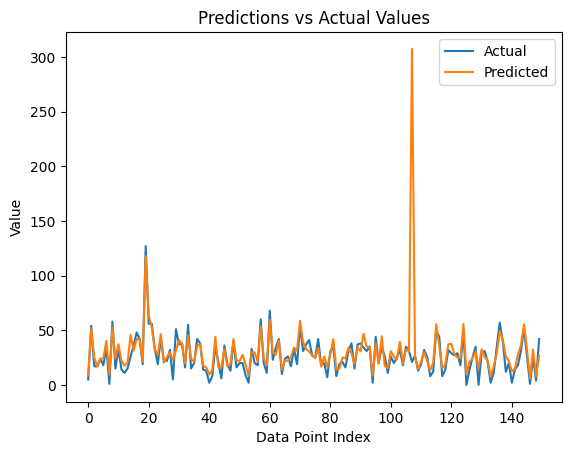

In [114]:
# Graph the predictions vs the actual values
import matplotlib.pyplot as plt

#plt.scatter(transaction_count_predictions, transaction_count_actuals, alpha=0.5)
plt.plot(transaction_count_actuals[650:800], label='Actual')
plt.plot(transaction_count_predictions[650:800], label='Predicted')
plt.xlabel('Data Point Index')
plt.ylabel('Value')
plt.title('Predictions vs Actual Values')
plt.legend()
plt.show()